In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1.Data Exploration:

## Load the dataset

In [50]:
data = pd.read_csv('FastagFraudDetection.csv')

## Display basic information and statistics

In [51]:
data.head()

,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator
0,1,1/6/2023 11:20,Bus,FTG-001-ABC-121,A-101,Express,Large,350,120,"13.059816123454882, 77.77068662374292",65,KA11AB1234,Fraud
1,2,1/7/2023 14:55,Car,FTG-002-XYZ-451,B-102,Regular,Small,120,100,"13.059816123454882, 77.77068662374292",78,KA66CD5678,Fraud
2,3,1/8/2023 18:25,Motorcycle,NaN,D-104,Regular,Small,0,0,"13.059816123454882, 77.77068662374292",53,KA88EF9012,Not Fraud
3,4,1/9/2023 2:05,Truck,FTG-044-LMN-322,C-103,Regular,Large,350,120,"13.059816123454882, 77.77068662374292",92,KA11GH3456,Fraud
4,5,1/10/2023 6:35,Van,FTG-505-DEF-652,B-102,Express,Medium,140,100,"13.059816123454882, 77.77068662374292",60,KA44IJ6789,Fraud


In [52]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Transaction_ID         5000 non-null   int64 
 1   Timestamp              5000 non-null   object
 2   Vehicle_Type           5000 non-null   object
 3   FastagID               4451 non-null   object
 4   TollBoothID            5000 non-null   object
 5   Lane_Type              5000 non-null   object
 6   Vehicle_Dimensions     5000 non-null   object
 7   Transaction_Amount     5000 non-null   int64 
 8   Amount_paid            5000 non-null   int64 
 9   Geographical_Location  5000 non-null   object
 10  Vehicle_Speed          5000 non-null   int64 
 11  Vehicle_Plate_Number   5000 non-null   object
 12  Fraud_indicator        5000 non-null   object
dtypes: int64(4), object(9)
memory usage: 507.9+ KB
None


In [53]:
print(data.describe())

       Transaction_ID  Transaction_Amount  Amount_paid  Vehicle_Speed
count     5000.000000          5000.00000  5000.000000    5000.000000
mean      2500.500000           161.06200   141.261000      67.851200
std       1443.520003           112.44995   106.480996      16.597547
min          1.000000             0.00000     0.000000      10.000000
25%       1250.750000           100.00000    90.000000      54.000000
50%       2500.500000           130.00000   120.000000      67.000000
75%       3750.250000           290.00000   160.000000      82.000000
max       5000.000000           350.00000   350.000000     118.000000


## Visualize the distribution of the fraud indicator

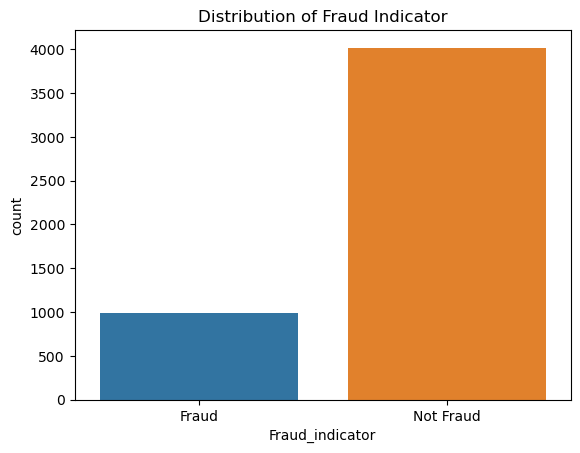

In [54]:
sns.countplot(x='Fraud_indicator', data=data)
plt.title('Distribution of Fraud Indicator')
plt.show()

## Visualize feature distributions

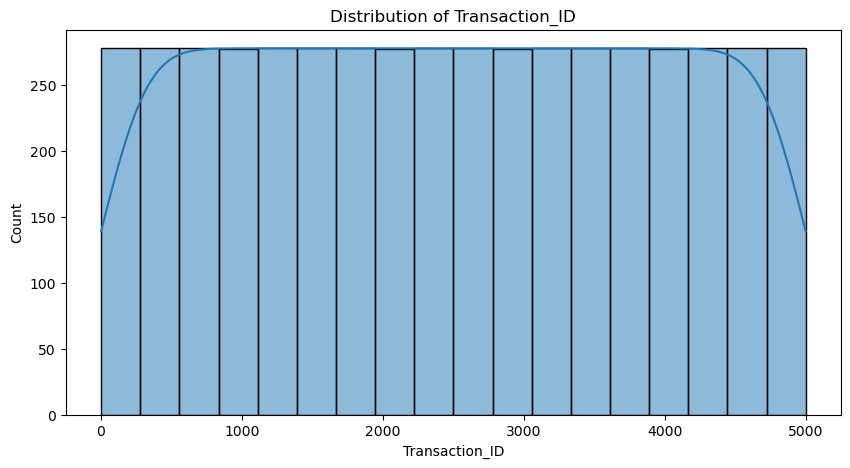

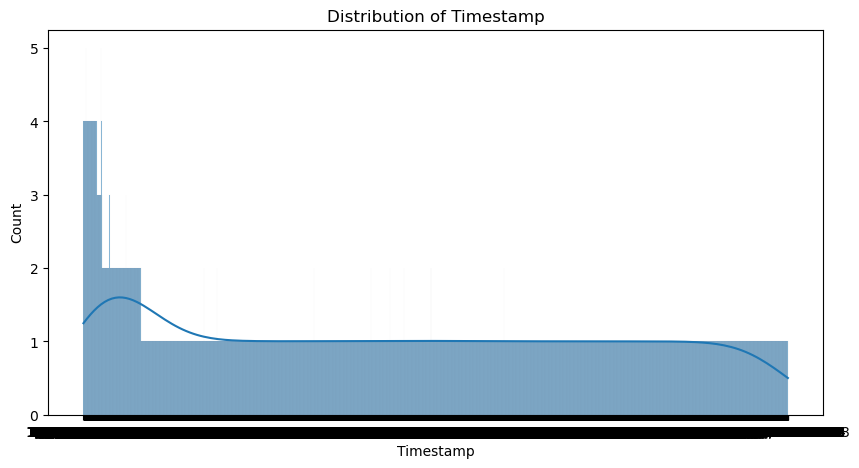

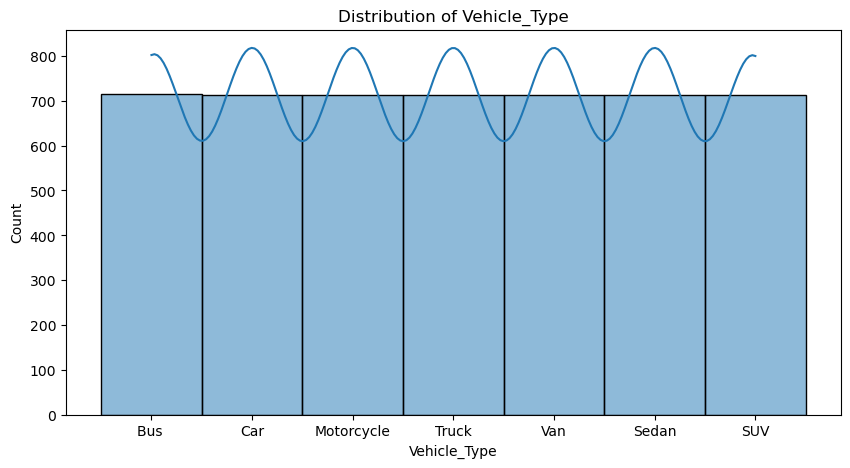

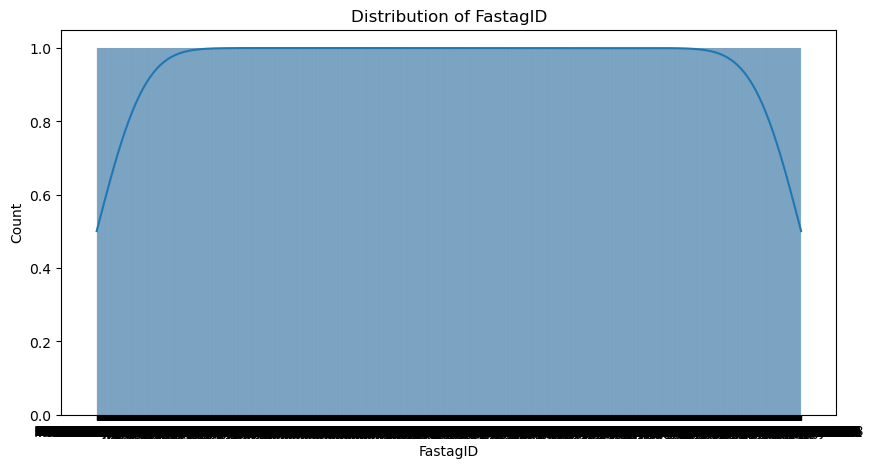

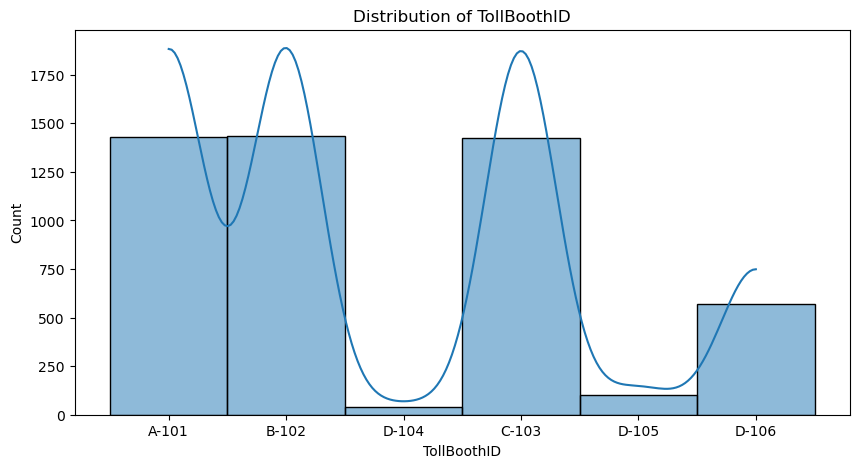

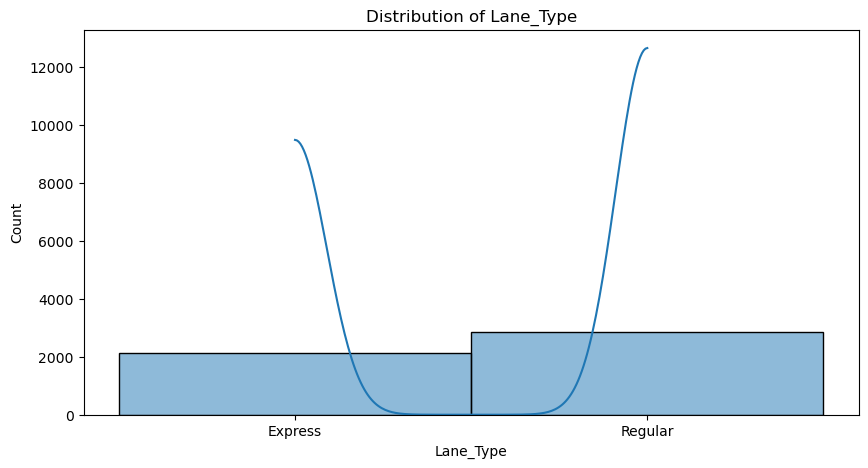

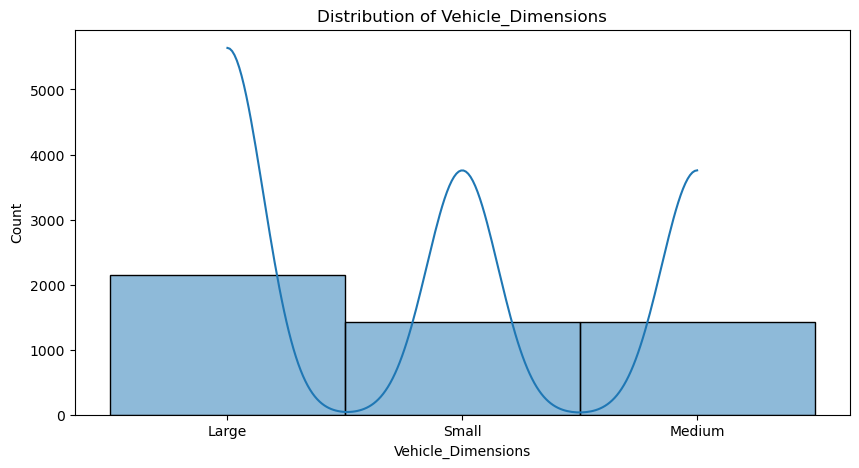

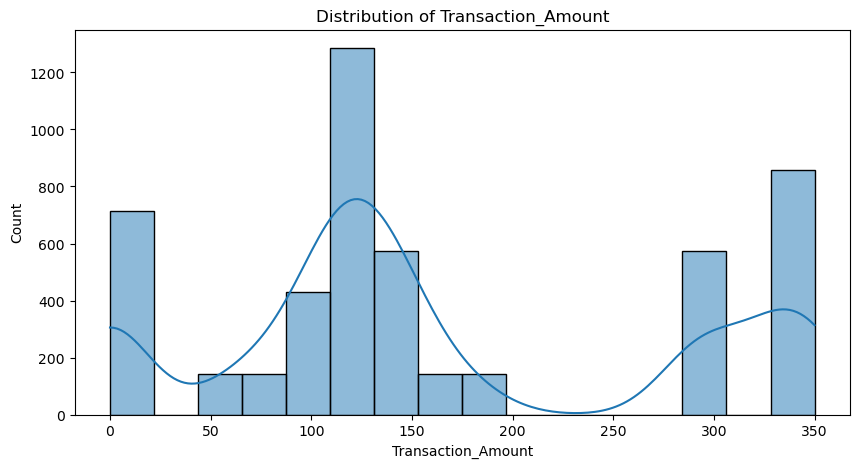

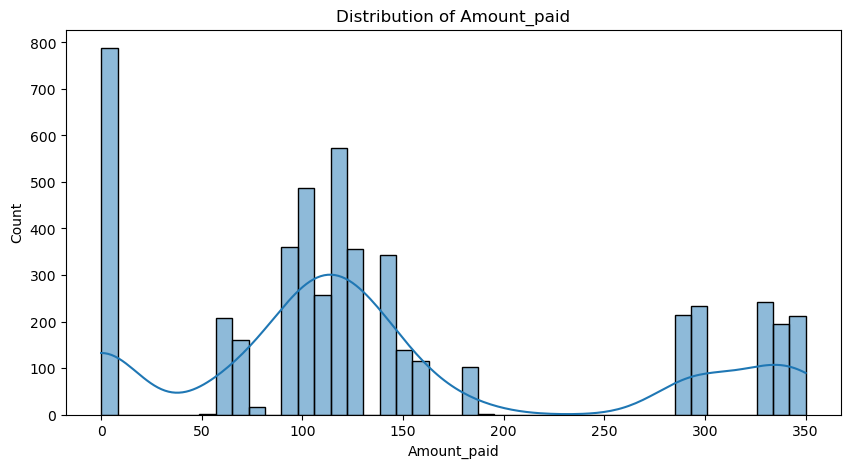

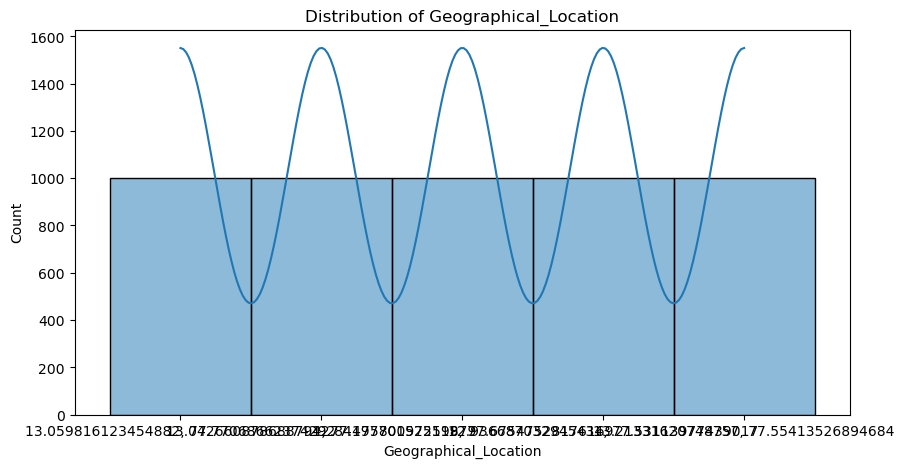

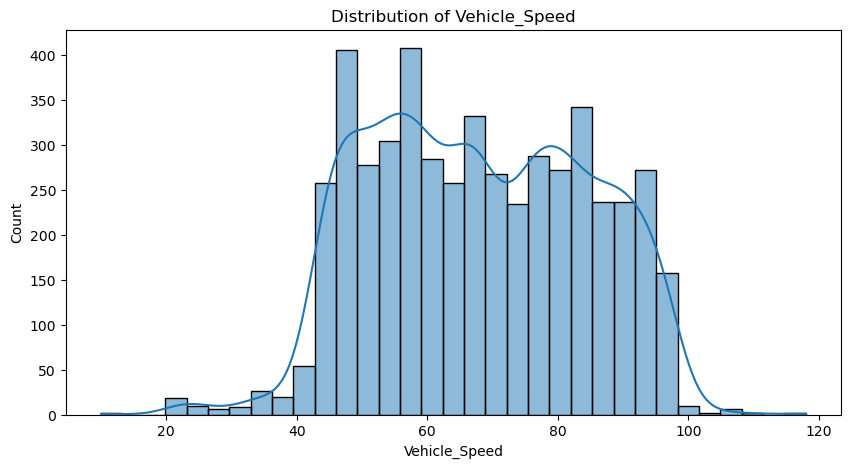

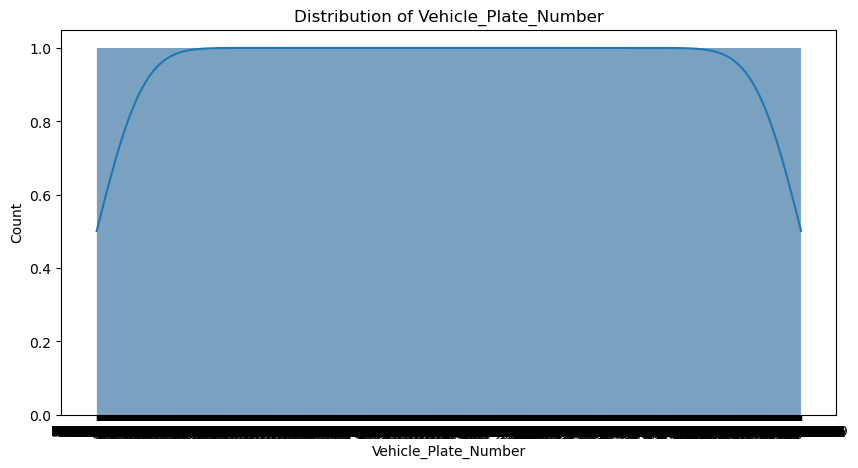

In [55]:
for column in data.columns:
    if column != 'Fraud_indicator':
        plt.figure(figsize=(10, 5))
        sns.histplot(data[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.show()

# 2 Feature Engineering:

In [56]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import shap

## Handle missing values

In [57]:
imputer = SimpleImputer(strategy='mean')
data['Vehicle_Speed'] = imputer.fit_transform(data[['Vehicle_Speed']])

## Encode categorical variables 

In [58]:
label_encoder = LabelEncoder()
data['Vehicle_Dimensions'] = label_encoder.fit_transform(data['Vehicle_Dimensions'])

## Encode Other Categorical Variables

In [59]:
categorical_features = ['Vehicle_Type', 'Lane_Type', 'Geographical_Location']
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
encoded_features = encoder.fit_transform(data[categorical_features])

## Scale numerical features

In [60]:
numerical_features = ['Transaction_Amount', 'Amount_paid', 'Vehicle_Speed', 'Vehicle_Dimensions']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numerical_features])

## Create New Features from Timestamp

In [61]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
time_features = data[['Hour', 'DayOfWeek']]

## Combine All Features

In [62]:
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
scaled_features_df = pd.DataFrame(scaled_features, columns=numerical_features)
X = pd.concat([encoded_features_df, scaled_features_df, time_features], axis=1)
y = data['Fraud_indicator']

## Split the Data

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Handle Class Imbalance with SMOTE

In [64]:
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## Train a Random Forest Model

In [65]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

## Make Predictions

In [66]:
y_pred = model.predict(X_test)

## Evaluate the Model

In [67]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       Fraud       1.00      0.96      0.98       197
   Not Fraud       0.99      1.00      1.00       803

    accuracy                           0.99      1000
   macro avg       1.00      0.98      0.99      1000
weighted avg       0.99      0.99      0.99      1000

[[189   8]
 [  0 803]]


## Hyperparameter tuning

In [68]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train_res, y_train_res)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))


G:\My Files\Anaconda\Anaconda Files\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "G:\My Files\Anaconda\Anaconda Files\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "G:\My Files\Anaconda\Anaconda Files\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "G:\My Files\Anaconda\Anaconda Files\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "G:\My Files\Anaconda\Anaconda Files\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "G:\My Files\Anaconda\Anaconda Files\lib\site-packages\sklearn\metrics\_classification.py", line 1287, i

              precision    recall  f1-score   support

       Fraud       1.00      0.93      0.96       197
   Not Fraud       0.98      1.00      0.99       803

    accuracy                           0.99      1000
   macro avg       0.99      0.96      0.98      1000
weighted avg       0.99      0.99      0.99      1000



## SHAP Analysis

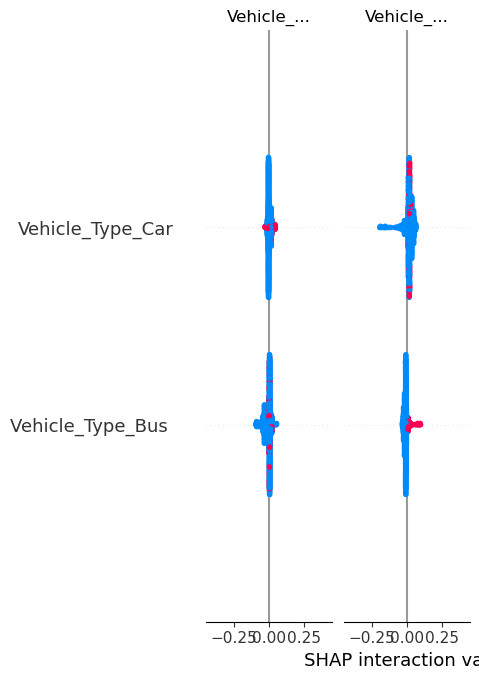

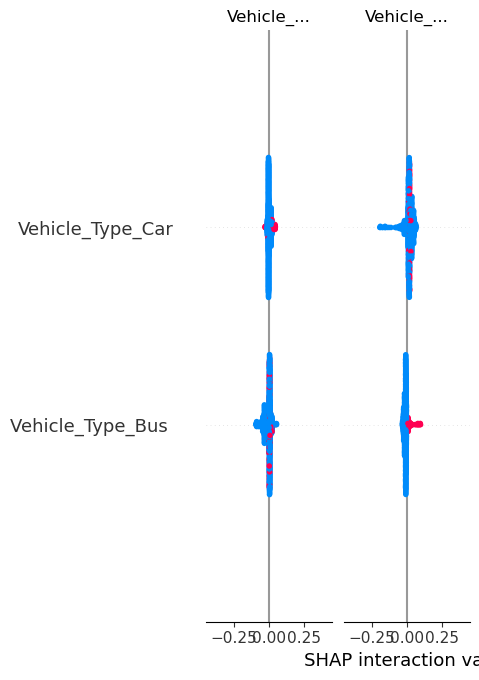

In [69]:
# SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Feature importance
shap.summary_plot(shap_values, X_test, plot_type='bar')
